# HoneyBee Workshop Part 1: Clinical Text Preprocessing with Multiple LLMs

## 1. Setup and Imports

In [1]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import torch
from transformers import AutoTokenizer, AutoModel, AutoProcessor, AutoModelForImageTextToText
warnings.filterwarnings('ignore')

# Add HoneyBee to path
sys.path.append('/mnt/f/Projects/HoneyBee')

# Import HoneyBee components
from honeybee.loaders import Reader
from honeybee.processors import ClinicalProcessor
from honeybee.models import HuggingFaceEmbedder

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("HoneyBee clinical processing modules loaded successfully!")

Using device: cuda
HoneyBee clinical processing modules loaded successfully!


## 2. Load Sample Clinical Data

We'll use the sample PDF clinical report provided in the examples folder.

In [2]:
# Path to sample clinical report
sample_pdf = "../samples/sample.pdf"

# Initialize the clinical data loader
reader = Reader.reader.PDF()

# Load the PDF
print(f"Loading clinical report from: {sample_pdf}")
clinical_text = reader.read(sample_pdf)

# Display first 500 characters
print("\nFirst 500 characters of the clinical report:")
print("-" * 50)
print(clinical_text[:500])
print("-" * 50)

Loading clinical report from: ../samples/sample.pdf

First 500 characters of the clinical report:
--------------------------------------------------
Patient Name:  PATIENT P.N 1 AGESEX: M :RIN NAME :  AGESEX: PHYSICIAN:MATH.NO MED. REC. NO: SURGERY DATE: RECEIVE DATE:UUID:4854A37F- 5F68-4EA0-99F7-E0572EA9533F TCGA-06-0150-01A-PR Redacted iii 111111111111111111111111a111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111 1111 111 III ---------------------------------------------------------------- PATHOLOGICAL DIAGNOSIS: BRAIN BIOPSY: GLIOBLASTOMA 
--------------------------------------------------


## 3. Process Clinical Text

The ClinicalProcessor handles:
- Entity extraction (diseases, medications, procedures)
- Medical code normalization (SNOMED-CT, RxNorm, ICD-O-3)
- Temporal information extraction
- Text cleaning and structuring

In [3]:
import json

# Initialize the clinical processor
processor = ClinicalProcessor()

# Process the clinical text
print("Processing clinical text...")
processed_data = processor.process_text(clinical_text)

# Display extracted entities
print("\nExtracted Medical Entities:")
print("-" * 50)
print(json.dumps(processed_data, indent=2))

Processing clinical text...

Extracted Medical Entities:
--------------------------------------------------
{
  "text": "Patient Name:  PATIENT P.N 1 AGESEX: M :RIN NAME :  AGESEX: PHYSICIAN:MATH.NO MED. REC. NO: SURGERY DATE: RECEIVE DATE:UUID:4854A37F- 5F68-4EA0-99F7-E0572EA9533F TCGA-06-0150-01A-PR Redacted iii 111111111111111111111111a111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111 1111 111 III ---------------------------------------------------------------- PATHOLOGICAL DIAGNOSIS: BRAIN BIOPSY: GLIOBLASTOMA PROLIFERATIVE INDEX, MIB-1: MORE THAN 40. ---------------------------------------------------------------- OperationSpecimen: Brain tumor. F.S. Clinical History and Pre-Op Dx: None given. GROSS PATHOLOGY: The specimen is labeled brain biopsy consiting of 0.2 x 0.4 cm pink-white tissue. A portion of the specimen has been examined by frozen section and is submitted in cassette 1

## 4. Define Model Configurations

We'll use 4 state-of-the-art clinical/medical language models:
- **GatorTron**: Large clinical language model from University of Florida
- **Qwen**: Embedding model from Alibaba
- **Llama**: Meta's latest language model
- **MedGemma**: Google's medical-specific model

In [4]:
# Model configurations
models_config = {
    'gatortron': {
        'model_name': 'UFNLP/gatortron-base',
        'max_length': 512,
        'batch_size': 8,
        'model_type': 'standard',
        'embedding_dim': 1024
    },
    'qwen': {
        'model_name': 'Qwen/Qwen3-Embedding-0.6B',
        'max_length': 512,
        'batch_size': 8,
        'model_type': 'standard',
        'embedding_dim': 896
    },
    'llama': {
        'model_name': 'meta-llama/Llama-3.2-1B',
        'max_length': 2048,
        'batch_size': 4,
        'model_type': 'llama',
        'embedding_dim': 2048
    },
    'medgemma': {
        'model_name': 'google/medgemma-4b-pt',
        'max_length': None,
        'batch_size': 1,
        'model_type': 'medgemma',
        'embedding_dim': 4096
    }
}

## 5. Helper Functions for Embedding Generation

In [5]:
def mean_pooling(model_output, attention_mask):
    """Apply mean pooling to transformer outputs"""
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def generate_standard_embeddings(model_name, texts, max_length, batch_size, device):
    """Generate embeddings using standard transformer approach"""
    print(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
    model.eval()
    
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**encoded)
            batch_embeddings = mean_pooling(outputs, encoded['attention_mask'])
            embeddings.extend(batch_embeddings.cpu().numpy())
    
    return np.array(embeddings)

def generate_llama_embeddings(model_name, texts, max_length, batch_size, device):
    """Generate embeddings using Llama model with special handling"""
    print(f"Loading Llama model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    
    # Set padding token
    tokenizer.pad_token = tokenizer.eos_token
    model.eval()
    
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**encoded)
            batch_embeddings = mean_pooling(outputs, encoded['attention_mask'])
            embeddings.extend(batch_embeddings.cpu().numpy())
    
    return np.array(embeddings)

def generate_medgemma_embeddings(model_name, texts, device):
    """Generate embeddings using MedGemma model with special handling"""
    print(f"Loading MedGemma model: {model_name}")
    processor = AutoProcessor.from_pretrained(model_name)
    model = AutoModelForImageTextToText.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16
    ).to(device)
    model.eval()
    
    embeddings = []
    
    for text in texts:
        try:
            inputs = processor(text=text, return_tensors="pt", padding=True).to(device)
            
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)
                hidden_states = outputs.hidden_states[-1]
                embedding = hidden_states.mean(dim=1).squeeze().float().cpu().numpy()
                embeddings.append(embedding)
                
        except Exception as e:
            print(f"Error processing text: {e}")
            # Use zero embedding as fallback
            embeddings.append(np.zeros(4096))
    
    return np.array(embeddings)

## 6. Generate Clinical Embeddings with All Models

Now we'll generate embeddings using all 4 models and compare their outputs.

In [6]:
# Prepare sample texts for embedding
sample_texts = [
    clinical_text[:1000],  # First 1000 chars of the loaded clinical report
    "Patient presents with adenocarcinoma of the lung. Started on carboplatin and paclitaxel.",
    "Follow-up CT scan shows partial response to treatment. No new metastases identified.",
    "Pathology report confirms invasive ductal carcinoma, ER+/PR+/HER2-. Grade 2."
]

# Dictionary to store embeddings from each model
all_embeddings = {}

# Generate embeddings with each model
for model_key, config in models_config.items():
    print(f"\n{'='*60}")
    print(f"Processing with {model_key.upper()} model")
    print(f"{'='*60}")
    
    try:
        if config['model_type'] == 'standard':
            embeddings = generate_standard_embeddings(
                config['model_name'], 
                sample_texts,
                config['max_length'],
                config['batch_size'],
                device
            )
        elif config['model_type'] == 'llama':
            embeddings = generate_llama_embeddings(
                config['model_name'],
                sample_texts,
                config['max_length'],
                config['batch_size'],
                device
            )
        elif config['model_type'] == 'medgemma':
            embeddings = generate_medgemma_embeddings(
                config['model_name'],
                sample_texts,
                device
            )
        
        all_embeddings[model_key] = embeddings
        print(f"Generated embeddings shape: {embeddings.shape}")
        print(f"Expected embedding dimension: {config['embedding_dim']}")
        
    except Exception as e:
        print(f"Error with {model_key}: {str(e)}")
        # Try using HuggingFaceEmbedder as fallback for standard models
        if config['model_type'] == 'standard':
            try:
                print(f"Trying HuggingFaceEmbedder for {model_key}...")
                embedder = HuggingFaceEmbedder(
                    model_name=config['model_name'], 
                    pooling_method='pooler_output'
                )
                embeddings = []
                for text in sample_texts:
                    emb = embedder.generate_embeddings(text)
                    embeddings.append(emb)
                all_embeddings[model_key] = np.vstack(embeddings)
                print(f"Success! Generated embeddings shape: {all_embeddings[model_key].shape}")
            except Exception as e2:
                print(f"Fallback also failed: {str(e2)}")


Processing with GATORTRON model
Loading model: UFNLP/gatortron-base
Generated embeddings shape: (4, 1024)
Expected embedding dimension: 1024

Processing with QWEN model
Loading model: Qwen/Qwen3-Embedding-0.6B
Generated embeddings shape: (4, 1024)
Expected embedding dimension: 896

Processing with LLAMA model
Loading Llama model: meta-llama/Llama-3.2-1B
Generated embeddings shape: (4, 2048)
Expected embedding dimension: 2048

Processing with MEDGEMMA model
Loading MedGemma model: google/medgemma-4b-pt


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generated embeddings shape: (4, 2560)
Expected embedding dimension: 4096


## 7. Compare Embedding Dimensions and Properties

In [7]:
# Compare embedding properties
print("\nEmbedding Comparison Summary:")
print("=" * 80)
print(f"{'Model':<15} {'Shape':<20} {'Dim':<10} {'Mean Norm':<15} {'Std Dev':<15}")
print("=" * 80)

for model_key, embeddings in all_embeddings.items():
    if embeddings is not None:
        mean_norm = np.mean(np.linalg.norm(embeddings, axis=1))
        std_dev = np.std(embeddings)
        print(f"{model_key:<15} {str(embeddings.shape):<20} {embeddings.shape[1]:<10} {mean_norm:<15.4f} {std_dev:<15.4f}")


Embedding Comparison Summary:
Model           Shape                Dim        Mean Norm       Std Dev        
gatortron       (4, 1024)            1024       10.2848         0.3215         
qwen            (4, 1024)            1024       73.0005         2.2895         
llama           (4, 2048)            2048       68.6433         1.5220         
medgemma        (4, 2560)            2560       139.3496        3.1034         


## 8. Visualize Embedding Similarities

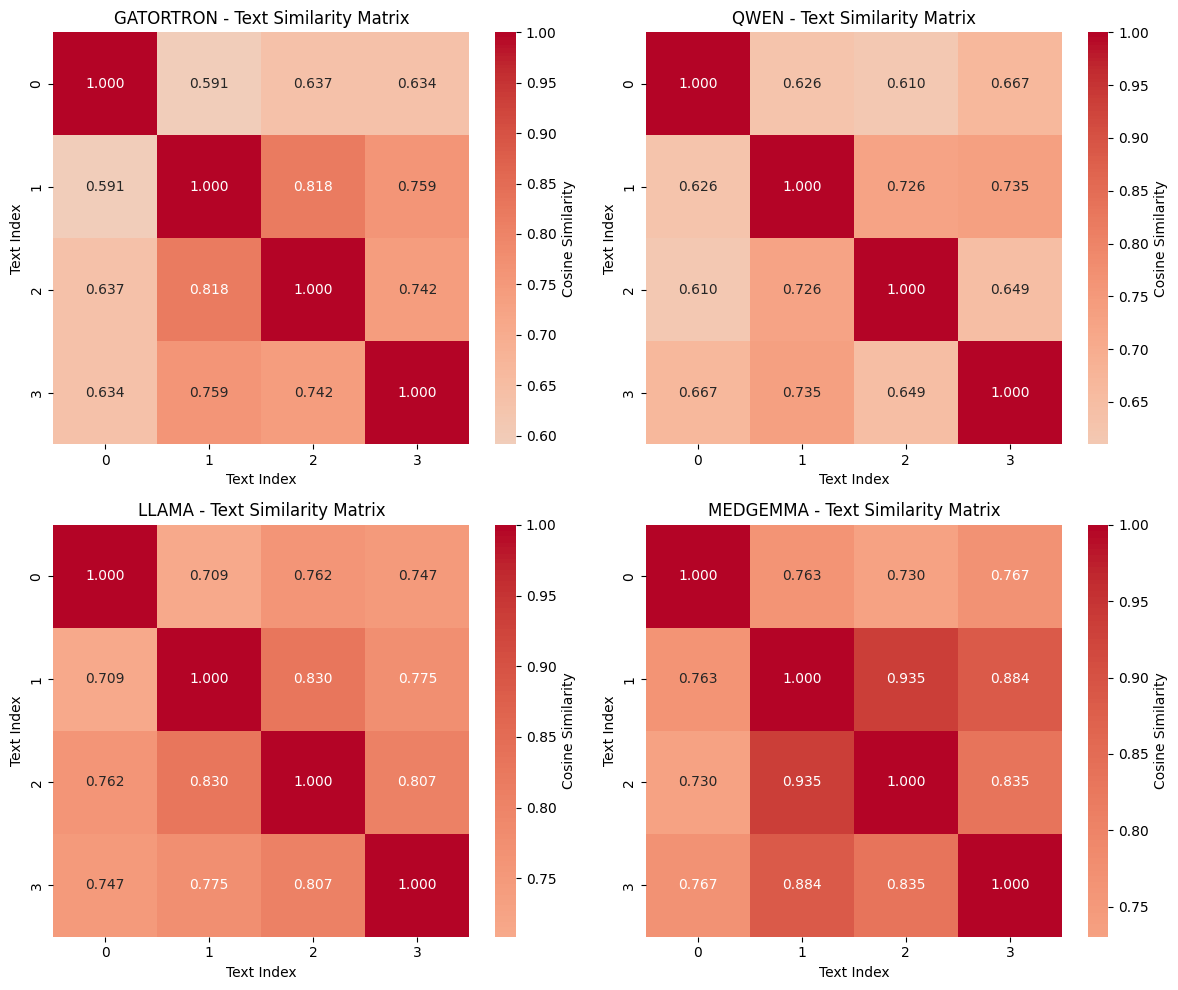

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarities between texts for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (model_key, embeddings) in enumerate(all_embeddings.items()):
    if embeddings is not None and idx < 4:
        # Calculate similarity matrix
        similarity_matrix = cosine_similarity(embeddings)
        
        # Plot heatmap
        ax = axes[idx]
        sns.heatmap(similarity_matrix, 
                    annot=True, 
                    fmt='.3f',
                    cmap='coolwarm',
                    center=0.5,
                    ax=ax,
                    cbar_kws={'label': 'Cosine Similarity'})
        ax.set_title(f'{model_key.upper()} - Text Similarity Matrix')
        ax.set_xlabel('Text Index')
        ax.set_ylabel('Text Index')

plt.tight_layout()
plt.show()

## 9. Batch Processing with Progress Tracking

In [9]:
from tqdm import tqdm

# Example: Process a larger batch of clinical texts
# In practice, you would load these from your dataset
large_batch_texts = sample_texts * 25  # Create 100 texts for demonstration

print(f"\nProcessing batch of {len(large_batch_texts)} clinical texts...")

# Choose the most efficient model for batch processing
selected_model = 'gatortron'  # or 'qwen' for faster processing
config = models_config[selected_model]

print(f"Using {selected_model.upper()} for batch processing")

# Process in batches with progress bar
batch_embeddings = []
batch_size = config['batch_size']

try:
    if config['model_type'] == 'standard':
        # Use HuggingFaceEmbedder for easier batch processing
        embedder = HuggingFaceEmbedder(
            model_name=config['model_name'],
            pooling_method='pooler_output'
        )
        
        for i in tqdm(range(0, len(large_batch_texts), batch_size), desc="Generating embeddings"):
            batch = large_batch_texts[i:i+batch_size]
            for text in batch:
                emb = embedder.generate_embeddings(text)
                batch_embeddings.append(emb)
        
        batch_embeddings = np.vstack(batch_embeddings)
        print(f"\nBatch processing complete! Shape: {batch_embeddings.shape}")
        
except Exception as e:
    print(f"Error in batch processing: {str(e)}")


Processing batch of 100 clinical texts...
Using GATORTRON for batch processing


Generating embeddings: 100%|██████████| 13/13 [00:01<00:00,  9.55it/s]


Batch processing complete! Shape: (100, 1024)


## 10. Save Embeddings for Downstream Tasks

In [10]:
# Create output directory
output_dir = Path("/mnt/f/Projects/HoneyBee/examples/mayo/outputs")
output_dir.mkdir(exist_ok=True)

# Save embeddings from all models
for model_key, embeddings in all_embeddings.items():
    if embeddings is not None:
        # Save as numpy array
        np.save(output_dir / f"clinical_embeddings_{model_key}.npy", embeddings)
        print(f"Saved {model_key} embeddings to: {output_dir / f'clinical_embeddings_{model_key}.npy'}")

# Save metadata with model information
metadata = []
for i, text in enumerate(sample_texts):
    record = {
        'text_id': f'sample_{i+1}',
        'text_preview': text[:50] + '...',
        'text_length': len(text)
    }
    # Add embedding indices for each model
    for model_key in all_embeddings.keys():
        if all_embeddings[model_key] is not None:
            record[f'{model_key}_embedding_dim'] = all_embeddings[model_key].shape[1]
    metadata.append(record)

metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv(output_dir / "clinical_metadata_all_models.csv", index=False)
print(f"\nSaved metadata to: {output_dir / 'clinical_metadata_all_models.csv'}")

Saved gatortron embeddings to: /mnt/f/Projects/HoneyBee/examples/mayo/outputs/clinical_embeddings_gatortron.npy
Saved qwen embeddings to: /mnt/f/Projects/HoneyBee/examples/mayo/outputs/clinical_embeddings_qwen.npy
Saved llama embeddings to: /mnt/f/Projects/HoneyBee/examples/mayo/outputs/clinical_embeddings_llama.npy
Saved medgemma embeddings to: /mnt/f/Projects/HoneyBee/examples/mayo/outputs/clinical_embeddings_medgemma.npy

Saved metadata to: /mnt/f/Projects/HoneyBee/examples/mayo/outputs/clinical_metadata_all_models.csv


## 11. Model Selection Guidelines

Based on the characteristics of each model, here are recommendations for different use cases:

### Model Comparison

| Model | Best For | Pros | Cons |
|-------|----------|------|------|
| **GatorTron** | Clinical NLP tasks | - Trained on clinical data<br>- Good balance of performance/size | - Limited context window (512 tokens) |
| **Qwen** | General embeddings | - Efficient embedding model<br>- Fast inference | - Not medical-specific |
| **Llama** | Long clinical texts | - Large context window (2048)<br>- State-of-the-art LLM | - Larger compute requirements |
| **MedGemma** | Medical understanding | - Medical-specific training<br>- Multimodal capabilities | - Slowest inference<br>- Largest memory footprint |

## 12. Integration with HuggingFace Datasets

For larger scale processing, we can load pre-computed TCGA embeddings or generate new ones:

In [11]:
# Example of loading pre-computed TCGA embeddings
from datasets import load_dataset

print("Available TCGA clinical embeddings from HuggingFace:")
print("Dataset: https://huggingface.co/datasets/Lab-Rasool/TCGA")
print("\nPre-computed embeddings available for:")
print("- GatorTron (clinical text)")
print("- Multiple cancer types")
print("- Survival information")
print("\nTo load:")
print("clinical_dataset = load_dataset('Lab-Rasool/TCGA', 'clinical', split='gatortron')")

INFO:datasets:PyTorch version 2.7.0 available.
INFO:datasets:Duckdb version 1.2.1 available.


Available TCGA clinical embeddings from HuggingFace:
Dataset: https://huggingface.co/datasets/Lab-Rasool/TCGA

Pre-computed embeddings available for:
- GatorTron (clinical text)
- Multiple cancer types
- Survival information

To load:
clinical_dataset = load_dataset('Lab-Rasool/TCGA', 'clinical', split='gatortron')


## Summary and Next Steps

In this enhanced workshop, you learned to:
1. ✅ Load and process clinical text from PDFs
2. ✅ Generate embeddings using 4 different state-of-the-art models
3. ✅ Compare embedding characteristics across models
4. ✅ Handle model-specific requirements (tokenization, pooling)
5. ✅ Visualize embedding similarities
6. ✅ Save embeddings for downstream analysis

**Next Workshop**: Part 2 - Radiology DICOM Processing

**Key Takeaways**:
- Different models excel at different aspects of clinical text
- GatorTron is optimized for clinical data
- Llama handles longer contexts well
- MedGemma offers medical-specific understanding
- Choose models based on your specific use case and computational resources